# MPS using the deesse wrapper - basics

## Main points addressed:
- simple deesse simulations of a categorical variable, with hard data points
- basic statistics on the results
- deesse simulation using pyramids (multi-resolution)

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import from package 'geone'
from geone import img
import geone.imgplot as imgplt
import geone.customcolors as ccol
import geone.deesseinterface as dsi

## Training image (TI)

The file `ti.gslib` has the following format:
```    
    Nx Ny Nz [Sx Sy Sz [Ox Oy Oz]]
    nvar
    name_of_variable_1
    ...
    name_of_variable_nvar
    Z1(0)    ... Znvar(0)
    ...
    Z1(Ng-1) ... Znvar(Ng-1)
```
The file is read using the function `img.readImageGslib`, which returns an *image* (class `img.Img`).

In [2]:
ti = img.readImageGslib('ti.gslib')

Note that a variable can contain missing values. Such value is coded with `np.nan`. In the file, one can write for missing values the string `nan` or write the number passed by the (optional) parameter `missing_value` to the function `img.readImageGslib`. (The specific value used by the deesse library is `MPDS_MISSING_VALUE` from the module `geone.deesse_core.deesse`.) The file is then read for example as follows:  

`ti = img.readImageGslib('ti.gslib', missing_value=-9999999)`

## Plot the image using the function `imgplt.drawImage2D`

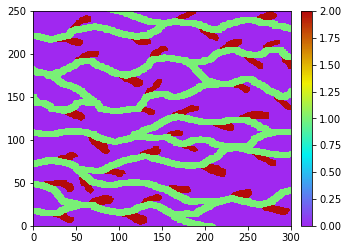

In [3]:
plt.figure(figsize=(5,5))
imgplt.drawImage2D(ti)

One can customize the output using options. For example, one can specify that it is a categorical image and specify the color used for each category.

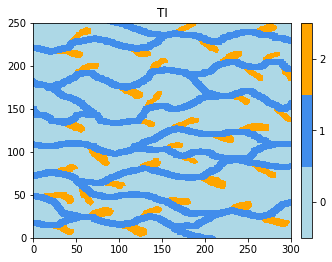

In [4]:
col = ['lightblue', [x/255. for x in ( 65, 141, 235)], 'orange']

plt.figure(figsize=(5,5))
imgplt.drawImage2D(ti, categ=True, categCol=col, title='TI')

## Hard data (point set)

The file `hd.gslib` has the following format:
```    
    npoint
    nvar+3
    name_for_x_coordinate
    name_for_y_coordinate
    name_for_z_coordinate
    name_of_variable_1
    ...
    name_of_variable_nvar
    x(1)      y(1)      z(1)      Z1(1)      ... Znvar(1)
    ...
    x(npoint) y(npoint) z(npoint) Z1(npoint) ... Znvar(npoint)
```
The file is read using the function `img.readPointSetGslib`, which returns a *point set* (class `img.PointSet`).

In [5]:
hd = img.readPointSetGslib('hd.gslib')
hd.varname

['x', 'y', 'z', 'code']

## Input structure for deesse (class `dsi.DeesseInput`)
The variable name for the hard data (in `hd.varname`) and for the simulated variable (parameter `varname` below) should be the same, otherwise, the hard data will be ignored. Moreover, the hard data locations should be in the simulation grid, which is described by its dimensions (number of cells) in each direction, the cell unit in each direction, and the origin (the *corner* of the grid cell with the minimal x, y, z coordinates). Hard data points out of the simulation grid are ignored.  

The hard data can be passed to deesse through a *point set*, i.e. a class `img.PointSet` (parameter `dataPointSet`, as below) or through an *image*, i.e. a class `img.Img` (parameter `dataImage`, not illustrated here), and can contain missing (uninformed) data, using the value `np.nan` or `MPDS_MISSING_VALUE` (not illustrated here).

In [6]:
nreal = 20
deesse_input = dsi.DeesseInput(
    nx=100, ny=100, nz=1,     # dimension of the simulation grid (number of cells)
    sx=1.0, sy=1.0, sz=1.0,   # cells units in the simulation grid (here are the default values)
    ox=0.0, oy=0.0, oz=0.0,   # origin of the simulation grid (here are the default values)
    nv=1, varname='code',     # number of variable(s), name of the variable(s)
    nTI=1, TI=ti,             # number of TI(s), TI (class dsi.Img)
    dataPointSet=hd,          # hard data (optional)
    distanceType=0,           # distance type: proportion of mismatching nodes (categorical var., default)
    nneighboringNode=24,      # max. number of neighbors (for the patterns)
    distanceThreshold=0.05,   # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,     # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1, # number of post-processing path(s)
    seed=444,                 # seed (initialization of the random number generator)
    nrealization=nreal)       # number of realization(s)

## Launch deesse using the function `dsi.deesseRun`
Note that deesse is launched in parallel (code based on *OpenMP*). The number of threads used can be specified by the optional parameter `nthreads`. Specifying for this parameter a number `-n`, negative or zero, means that the maximal number of threads (on the machine) except `n` (but at least one) will be used. By default: `nthreads=-1`.

In [7]:
deesse_output = dsi.deesseRun(deesse_input)

********************************************************************************
DEESSE VERSION 3.0 / BUILD NUMBER 20190110
********************************************************************************
DONE


## Retrieve the results (and display)
The function `dsi.deesseRun` returns a dictionary `deesse_output = {'sim':sim, 'path':path, 'error':error}`, where `deesse_output['sim']` is a 1-dimensional array of *images* (class `img.Img`) of size `deesse_input.nrealization`, and `deesse_output['sim'][i]` is the i-th realization. The simulation path and error map for each realization can also be retrieved in `deesse_output['path']` and `deesse_output['error']` respectively (see example dedicated to this topic), however, they are set to `None` by default.


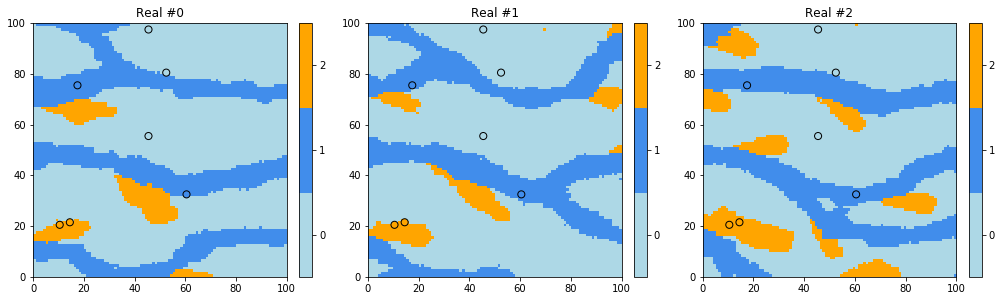

In [8]:
# Retrieve the realizations
sim = deesse_output['sim']

# Display
import matplotlib.colors
hd_col=[matplotlib.colors.to_rgba(col[int(v)]) for v in hd.val[3]] # colors (converted to 'rgba') 
                                                                   # of hard data points

plt.subplots(1, 3, figsize=(17,5)) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    imgplt.drawImage2D(sim[i], categ=True, categCol=col, title='Real #{}'.format(i)) # plot real #i
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, 
                color=hd_col, edgecolors='black', linewidths=1) # add hard data points

## Do some statistics on the realizations
The function `img.imageCategProp(im, categ)` allows to compute the pixel-wise proportions of given categories in the list `categ` over all the variables of the image `im`. Hence, we first define an image with `nreal` variables, each one corresponding to one realization, using the function `img.gatherImages`.

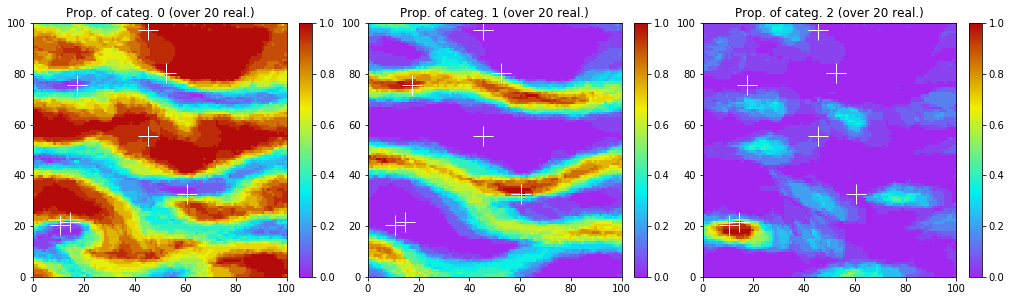

In [9]:
# Gather the nreal realizations into one image
all_sim = img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(1, 3, figsize=(17,5)) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    imgplt.drawImage2D(all_sim_stats, iv=i, 
                       title='Prop. of categ. {} (over {} real.)'.format(i, nreal))
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='white') # add hard data points


## Simulations using pyramids
Enabling pyramids implies multi-resolution simulations, which can help to better reproduce the spatial structures. It consists in considering lower resolutions of the TI and the simulation grid.  

### Parameters for pyramids (class `dsi.PyramidGeneralParameters` and class `dsi.PyramidParameters`)
Using pyramids requires to define:
- General parameters (class `dsi.PyramidGeneralParameters`):
    - the number of pyramid levels (`npyramidLevel`) additional to the original simulation grid
    - the reduction factors along each axis direction (`kx`, `ky`, `kz`, list of length `npyramidLevel`): the integers `kx[i]`, `ky[i]`, `kz[i]` are these factors between the level `i` and the level `i+1` (the number of cells in each direction are respectively divided by these factors), the simulation grid being the level `0`, and the lowest resolution being the level `npyramidLevel`. (A factor set to zero means that no reduction is made along the corresponding direction.)
- Parameters for each variable (one variable in this example (univariate simulation)):
    - the number of levels (`nlevel`, should be equal to `npyramidLevel` above)
    - the type of pyramid (`pyramidType`), which depends on the type of the variable

In [10]:
pyrGenParams = dsi.PyramidGeneralParameters(
    npyramidLevel=2,                 # number of pyramid levels, additional to the simulation grid
    kx=[2, 2], ky=[2, 2], kz=[0, 0]  # reduction factors from one level to the next one
                                     #    (kz=[0, 0]: do not apply reduction along z axis)
)

pyrParams = dsi.PyramidParameters(
    nlevel=2,                      # number of levels
    pyramidType='categorical_auto' # type of pyramid (accordingly to categorical variable in this example)
)

### Fill the input structure for deesse and launch deesse

In [11]:
deesse_input = dsi.DeesseInput(
    nx=100, ny=100, nz=1,
    nv=1, varname='code',
    nTI=1, TI=ti,
    dataPointSet=hd,
    distanceType=0,
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams, # set pyramid general parameters
    pyramidParameters=pyrParams,           # set pyramid parameters for each variable
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
deesse_output = dsi.deesseRun(deesse_input)

********************************************************************************
DEESSE VERSION 3.0 / BUILD NUMBER 20190110
********************************************************************************
DONE


### Results

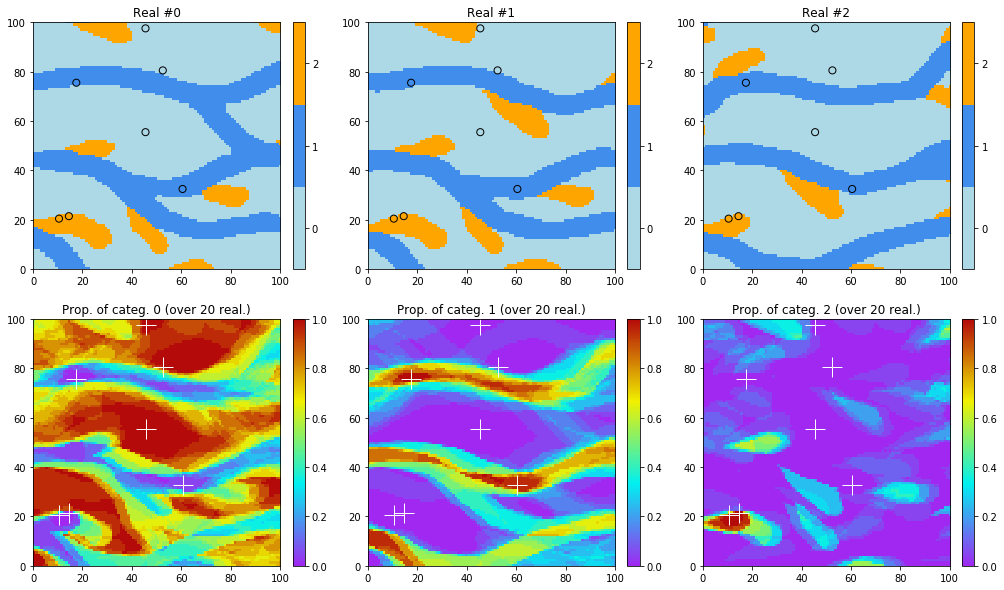

In [12]:
# Retrieve the realizations
sim = deesse_output['sim']

# Gather the nreal realizations into one image
all_sim = img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(2, 3, figsize=(17,10)) # 2 x 3 sub-plots
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    imgplt.drawImage2D(sim[i], categ=True, categCol=col, title='Real #{}'.format(i)) # plot real #i
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, 
                color=hd_col, edgecolors='black', linewidths=1) # add hard data points
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    imgplt.drawImage2D(all_sim_stats, iv=i, title='Prop. of categ. {} (over {} real.)'.format(i, nreal))
    plt.plot(hd.x(), hd.y(), '+', c='white', markersize=20) # add hard data points